In [2]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point, )
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import MyActuator_RMD_MT_RH_17_100_N, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot

### Parametrization

#### 1) mechanism configuration

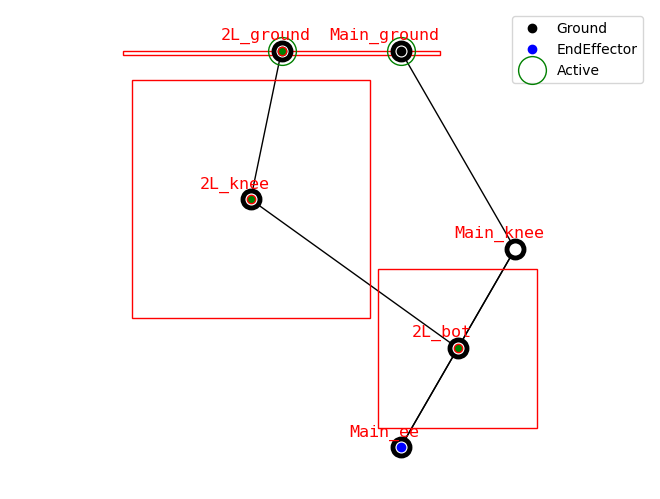

In [3]:
 


generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(shift=0.3)
graph, constrain_dict = all_graphs[0]

#actuator = TMotor_AK10_9()
actuator = MyActuator_RMD_MT_RH_17_100_N()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
draw_joint_point(graph)
visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

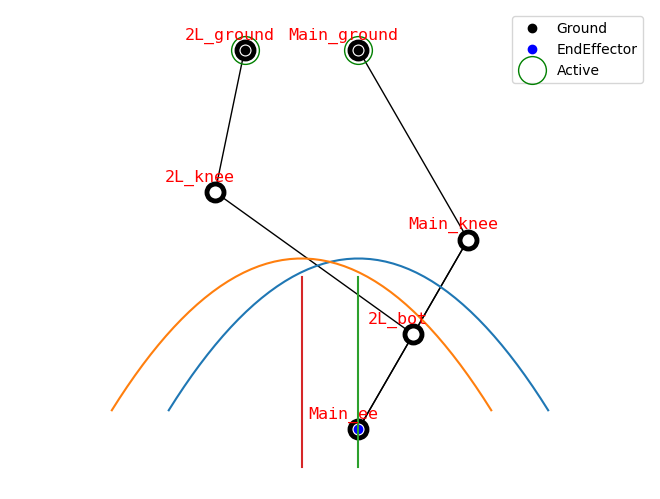

In [4]:
# trajectories
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.5, -0.95], step_height= 0.4, step_width=1,n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.65, -0.95], step_height= 0.4, step_width=1,n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.35, -0.95], step_height= 0.4, step_width=1,n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0,50))
left_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, -0.15,50))
right_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-1.1, 0.5, 0.15,50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1)]

step_trajectories = [ground_symmetric_step,left_shift_step,right_shift_step]
step_trajectories = [ground_symmetric_step, left_shift_step]

rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1),
           (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1)]

vertical_trajectories = [central_vertical, left_vertical, right_vertical]

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]


draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

#### Calculate rewards for initial graph.

In [5]:
# create builder
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    max_reward = -float('inf')
    max_partial = None
    best_trajectory = None
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
        if current_total > max_reward:
            max_reward = current_total
            max_partial = current_partial
            best_trajectory_id = trajectory_id

    print('Best trajectory id:', best_trajectory_id, 'partial rewards at best trajectory:', max_partial)
    trajectory = trajectories[best_trajectory_id]
    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards[1][0]
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])


Best trajectory id: 0 partial rewards at best trajectory: [0, 11.633227521166223]
Best trajectory id: 0 partial rewards at best trajectory: [0, 0]


In [6]:
# activate multiprocessing
N_PROCESS = 16
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [7]:
population_size = 32
n_generations = 60

# create the problem for the current optimization
problem = CalculateCriteriaProblemByWeigths(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            rewards_and_trajectories=rewards_and_trajectories,
                                            elementwise_runner=runner, Actuator = actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       32 |        - |       - |  0.9000 |  2.00000 |  2.00000 | -3.848179E+00 | -1.346190E+01
     2 |       64 |  0.00398 |       3 |  0.4025 |  2.00000 |  2.01352 | -6.426213E+00 | -1.529809E+01
     3 |       96 |  0.07517 |       3 |  0.4477 |  1.99337 |  2.02696 | -1.039675E+01 | -2.269128E+01
     4 |      128 | -1.4E-02 |       3 |  0.3911 |  1.98353 |  2.03562 | -1.315007E+01 | -2.269128E+01
     5 |      160 | -1.1E-02 |       3 |  0.3931 |  1.97448 |  2.04582 | -1.499717E+01 | -2.293991E+01
     6 |      192 | -9.1E-03 |       3 |  0.3944 |  1.96512 |  2.05729 | -1.681073E+01 | -2.338481E+01
     7 |      224 |  0.02330 |       3 |  0.4146 |  1.95507 |  2.07018 | -1.832356E+01 | -2.645415E+01
     8 |      256 |  0.02462 |       3 |  0.4155 |  1.94399 |  2.08325 | -1.896427E+01 | -2.645643E+01
     9 |      288 |  0.01886 |       3 |  0.4118 |  1.93187 |  2.08985 | 

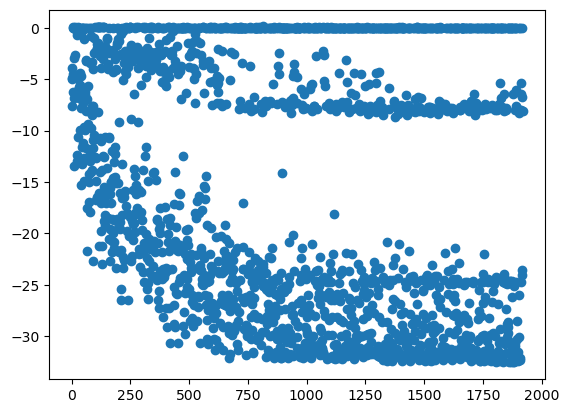

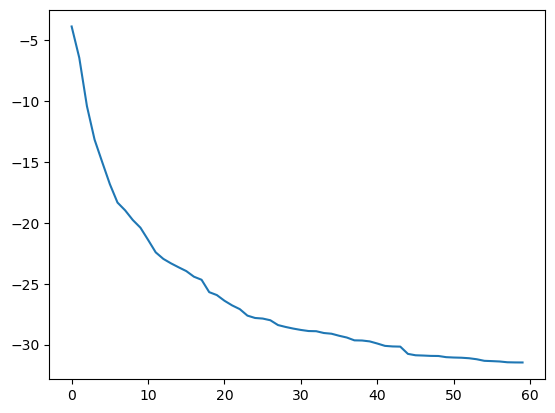

In [8]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [9]:
worst_id = np.argmax(optimizer.history["F"])
worst_reward = optimizer.history["F"][worst_id]
print('The maximum result in optimization task:', worst_reward.item())

The maximum result in optimization task: 0.13137415080642179


In [51]:
 
 
hist_flat = np.array(optimizer.history["F"]).flatten()
not_super_best_id = np.argsort(hist_flat)[400]
optimizer.history["F"][not_super_best_id]

array([-23.94748669])

The minimum result in optimization task: [-23.94748669]


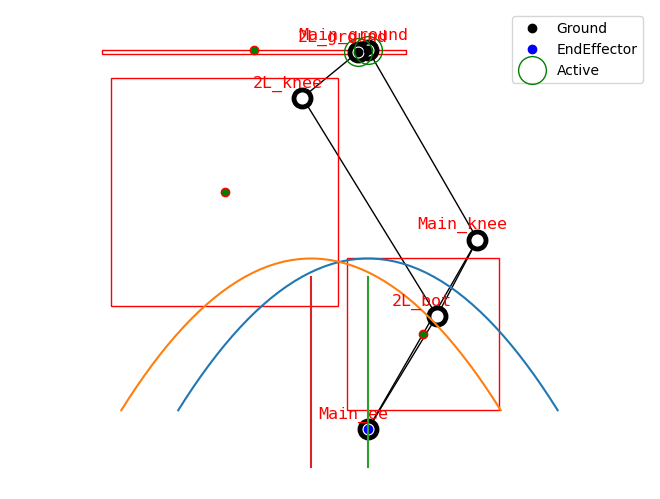

In [52]:
best_id = np.argmin(optimizer.history["F"])
best_id = not_super_best_id
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("The minimum result in optimization task:", best_reward)

problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])
visualize_constrains(problem.graph, constrain_dict)


In [54]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
optimizer.history["Fs"]

[array([[ 0.        , -0.00669877,  0.        ],
        [ 0.        ,  0.        ,  3.92640704]]),
 array([[1.        , 0.        , 4.92330105],
        [0.        , 0.        , 0.        ]]),
 array([[0.        , 0.        , 7.56162584],
        [0.        , 0.        , 0.        ]]),
 array([[0.        , 0.        , 4.98872914],
        [0.        , 0.        , 0.        ]]),
 array([[0.        , 0.        , 4.45390593],
        [0.        , 0.        , 0.        ]]),
 array([[ 1.        , -0.04827231,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]),
 array([[0.        , 0.        , 6.23194974],
        [0.        , 0.        , 0.        ]]),
 array([[ 1.        , -0.00642719,  0.        ],
        [ 0.        , -0.01540787,  0.        ]]),
 array([[1.       , 0.       , 6.8387629],
        [0.       , 0.       , 0.       ]]),
 array([[0.        , 0.        , 2.96001836],
        [0.        , 0.        , 0.        ]]),
 array([[ 1.        , -0.00246459,  0.        ],

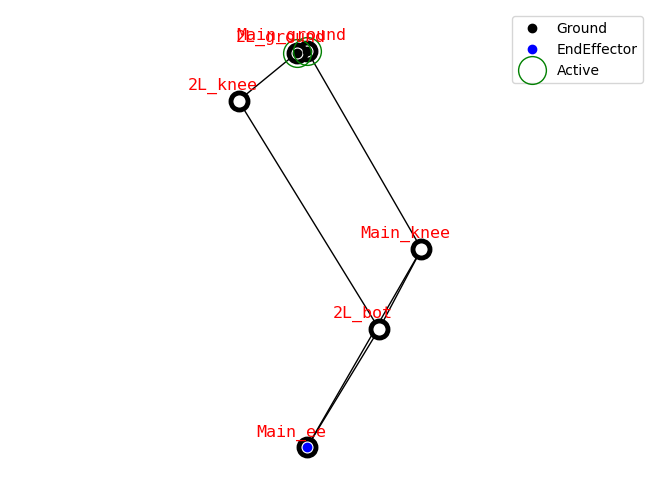

In [53]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

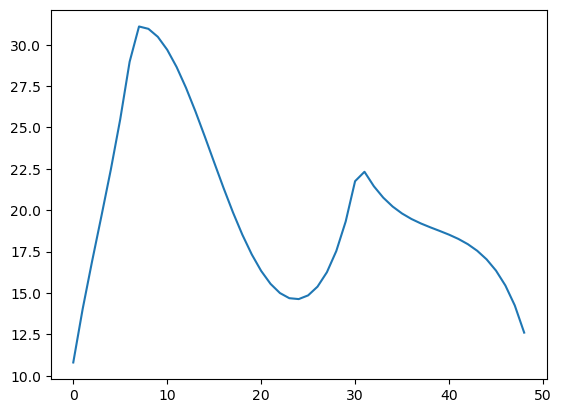

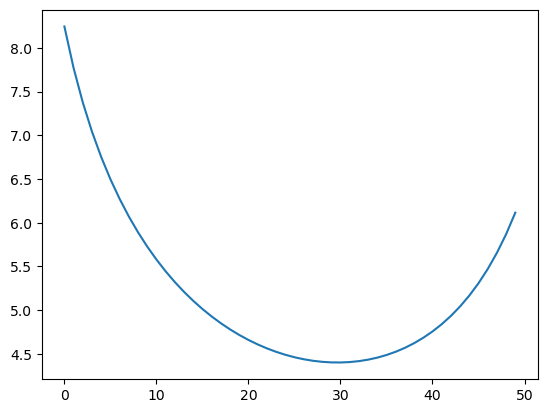

In [55]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
for i, reward_decomposition in enumerate(best_reward_decomposition):
    trajectory_id = int(reward_decomposition[0])
    trajectory = rewards_and_trajectories[i][1][trajectory_id]


    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards_and_trajectories[i][0][1][0]

    print(reward)
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
    plt.figure()
    plt.plot(reward_vector)
    reward_vector

1861